In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Reshape, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, UpSampling2D, UpSampling1D 
from keras.layers import LocallyConnected1D, LocallyConnected2D, LSTM, RepeatVector
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
dirname = config.dataset_dir + 'examples/'
config.info(dirname, len(os.listdir(dirname)))

 [INFO] : 
 |  ../datasets/examples/
 |  19


In [5]:
n = 100 * 1
dim4 = True
multiTrack = True
dn = 'drum_midi/'
context, x_train, labels = data.import_data(data.init(), n, dim4=dim4, dirname=dn, multiTrack=multiTrack, r=True)

Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  100.000000
 max_f: 25.000000, min_f: 0.500000
Importing midi-data


Encoding midi-data
 100
> -> multi-track = True
 [INFO] : 
 |  reduced dims:
 |  (100, 100, 18)


In [12]:
# n = 1000
# min_f = 0
# max_f = 3
# x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
#     n_polyrythms=1,
#     n_channels=3,
#     d_phase=True,
#     return_params=True,
#     dim4=dim4,
#     multiTrack=multiTrack)

In [13]:
x_train.shape

(90, 100, 18, 1)

In [14]:
m = int(x_train.shape[0] * 0.9)
[x_train.shape, m]

[(90, 100, 18, 1), 81]

In [15]:
x_test = x_train[m:]
x_train = x_train[:m]

m (50, 18)


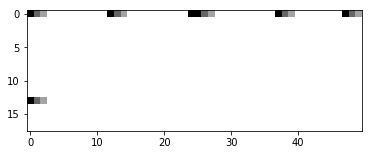

m (50, 18)


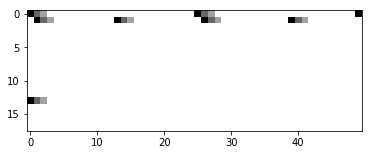

m (50, 18)


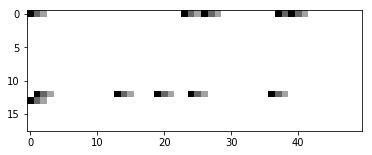

"../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"

In [16]:
plot.single(x_train[0, :50,:,0])
plot.single(x_train[1, :50,:,0])
plot.single(x_train[2, :50,:,0])
labels[0]

In [17]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(100, 18, 1)

In [18]:
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

In [123]:
def encoder(input_size, dropout=0.05):
    encoder_input = Input(shape=input_size)
    
    # Convolve & Pool
    h = encoder_input
    h = Reshape(input_shape[:-1])(h)
    h = Conv1D(32, kernel_size=2, strides=2, activation='relu', padding='valid')(h)
    h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
    h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='valid')(h)
    shape = K.int_shape(h)[1:]
    h = Reshape(list(shape) + [1])(h)
    h = Conv2D(128, kernel_size=(2,2), strides=1, activation='relu', padding='valid')(h)
    h = MaxPooling2D((2, 1))(h)

    h = Conv2D(64, kernel_size=(2,2), strides=2, activation='relu', padding='valid')(h)
#     print(shape, list(shape))

    # Dense layers
#     h = Dropout(dropout)(h) # uncomment when using larger batches
    h = Flatten()(h)
    h = Dropout(dropout)(h) # uncomment when using larger batches

    h = Dense(intermediate_dim, activation='relu')(h)
   
    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
        
    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, encoder_input, z_mean, z_log_var

In [124]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 100, 18, 1)   0                                            
__________________________________________________________________________________________________
reshape_15 (Reshape)            (None, 100, 18)      0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 50, 32)       1184        reshape_15[0][0]                 
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 49, 64)       4160        conv1d_13[0][0]                  
__________________________________________________________________________________________________
conv1d_15 

In [125]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [126]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)
# z_output = Lambda(sampl_, output_shape=(latent_dim,))(encoder_input)

In [127]:
def list_decoders(output_size, p='valid'):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_size
    m = 4 # multiplier for dims
    
    # at the start of upsampling, the image-structure does not yet have to correspond to the goal structure 
    # ?TODO use y*y*y starting dims, may conv, and only then correct the structure (?)
    output_shape = (timesteps, notes, channels)
    
    # we instantiate these layers separately so as to reuse them later
    decoders = []
#     decoders += [ Dense(intermediate_dim, activation='relu') ]
    decoders += [ Dense(intermediate_dim, activation='relu') ]
    decoders += [ Dense(intermediate_dim * 2, activation='relu') ]
    decoders += [ Dense(intermediate_dim * 1, activation='relu') ]
    
    decoders += [ Dense(np.prod(output_shape), activation='relu') ]
#     decoders += [ Reshape(output_shape[-3:]) ]
    
    # Convolve & Pool
    
    # Note that the kernel windows do not yet correspond to 'temporal' features, but rather to just spatial features
    k = (3,2) # (2,1) :: (timesteps, notes)
    s = (1,3)
    timesteps_ = int(timesteps / 2)
    
#     decoders += [ Conv2DTranspose(timesteps_, kernel_size=k, strides=3, activation='relu', padding=p) ]
#     decoders += [ Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p) ]
#     # decoder += [Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=(3,1), activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=3, activation='relu', padding=p)]
    
    # 'end' of upsampling
#     decoders += [ Conv2D(1, kernel_size=(1,2), strides=1, activation='relu', padding=p) ]
    # shape = ()
    # decoder_reshape2 = Reshape(dims[0:2])
    # #     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding=p)(h)
    # decoder_conv2 = Conv1D(notes * m, kernel_size=2, strides=2, activation='relu', padding=p)
    
    
    # Mean (output)
    #     h = Conv2D(1, kernel_size=1, strides=s, activation='sigmoid', padding='same')(h)
    output_shape = (timesteps, notes, channels)
    
#     decoders += [ Flatten()] # note that [].append != [] = []
    decoders += [ Dense(np.prod(output_shape), activation='sigmoid')]
    decoders += [ Reshape(output_shape)]
    return decoders

In [128]:
decoders = list_decoders(input_shape)

In [129]:
decoded = utils.composition(decoders, z_output, verbose=False)

In [130]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 100, 18, 1)   0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 2), (None, 2 1317476     input_8[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 2)            0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 128)          384         lambda_4[0][0]                   
__________

In [131]:
# Compute VAE loss
def vae_loss(beta=1.):
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + beta * kl_loss)
    return vae_loss

vae_loss = vae_loss(beta=1)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Output "reshape_17" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_17" during training.
  # This is added back by InteractiveShellApp.init_path()


In [140]:
batch_size = 200
epochs = 50
params = {'batch_size': batch_size, 'return_y': False}

In [141]:
phase_mod = 0.01
whitening = False

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by dataset std
#         samplewise_std_normalization=False,  # divide each input by its std
# #         zca_epsilon=10,
#         zca_whitening=whitening,
#         rotation_range=0,  # randomly rotate images in 0 to 180 degrees
#         width_shift_range=0.,  # note-channel mod, but not shuffled
#         height_shift_range=phase_mod,  # start_t, phase
#         horizontal_flip=False,  # reverse
#         vertical_flip=False)

# # datagen.fit(x_train)

In [142]:
x_train.shape

(81, 100, 18, 1)

In [143]:
m = 1000
useDataGenerator = False
useDataGenerator = True

print('batch_size =', batch_size)
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>>>>' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x_train[:m], x_train[:m], batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x = x_batch
#             x = datagen.shuffle_3rd_dim(x_batch)
            h = vae.fit(x, verbose=0)
            for k,v in h.history.items(): 
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x_train[:m], epochs=epochs, validation_data=(x_test, None))
    history = h.history

batch_size = 200

[Epoch 0/50] >>>>>>>>>>>>
 Batch 0/0
Epoch 1/1
81/81 [==============================] - 1s 11ms/step - loss: 81.5189

[Epoch 1/50] >>>>>>>>>>>>
 Batch 0/0
Epoch 1/1
81/81 [==============================] - 1s 11ms/step - loss: 82.1054

[Epoch 2/50] >>>>>>>>>>>>
 Batch 0/0
Epoch 1/1
81/81 [==============================] - 1s 12ms/step - loss: 80.5919

[Epoch 3/50] >>>>>>>>>>>>
 Batch 0/0
Epoch 1/1
81/81 [==============================] - 1s 12ms/step - loss: 78.7756

[Epoch 4/50] >>>>>>>>>>>>
 Batch 0/0
Epoch 1/1
81/81 [==============================] - 1s 13ms/step - loss: 82.3343

[Epoch 5/50] >>>>>>>>>>>>
 Batch 0/0
Epoch 1/1
81/81 [==============================] - 1s 13ms/step - loss: 77.6196

[Epoch 6/50] >>>>>>>>>>>>
 Batch 0/0
Epoch 1/1
81/81 [==============================] - 1s 11ms/step - loss: 78.6359

[Epoch 7/50] >>>>>>>>>>>>
 Batch 0/0
Epoch 1/1
81/81 [==============================] - 1s 12ms/step - loss: 79.6469

[Epoch 8/50] >>>>>>>>>>>>
 Batch 0/0
E

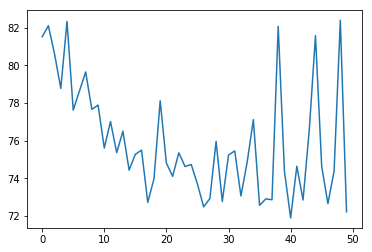

In [144]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

m (50, 18)


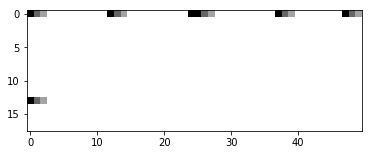

m (50, 18)


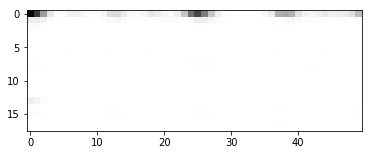

m (50, 18)


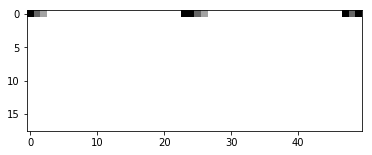

m (50, 18)


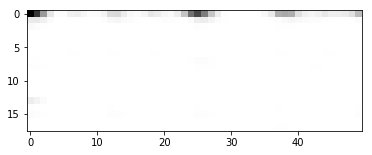

m (50, 18)


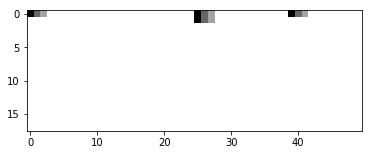

m (50, 18)


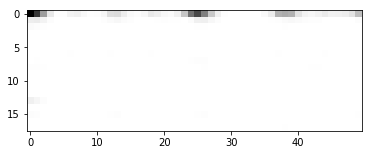

In [169]:
i = 0
j = 30
k = -1
x = vae.predict(x_train[:100])
plot.single(x_train[i, :50, :, 0])
plot.single(x[i, :50, :, 0])
plot.single(x_train[j, :50, :, 0])
plot.single(x[j, :50, :, 0])
plot.single(x_train[k, :50, :, 0])
plot.single(x[k, :50, :, 0])

In [146]:
x.shape

(10, 100, 18, 1)

m (30, 18)


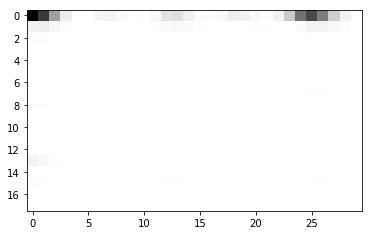

In [147]:
# min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

m (30, 18)


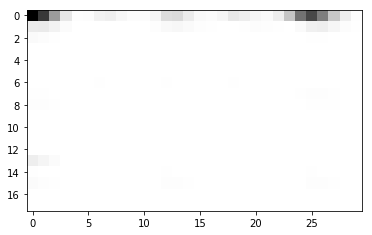

In [148]:
# mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

## Encoder + Generator
A model to project inputs on the latent space

In [149]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [150]:
x_test.shape

(9, 100, 18, 1)

In [151]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(81, 2)

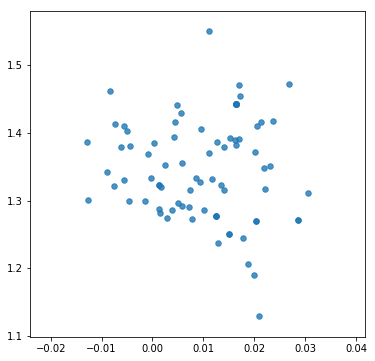

In [152]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.8, s=30) # c=y_test, 

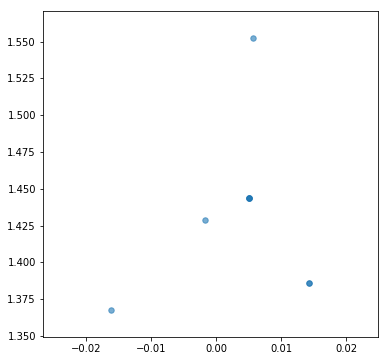

In [153]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.6, s=30) # , c=y_test
# plt.colorbar()

In [154]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [155]:
# x_decoded[0].reshape(150,3)

In [156]:
x_train.shape

(81, 100, 18, 1)

(2,) [0. 0.]


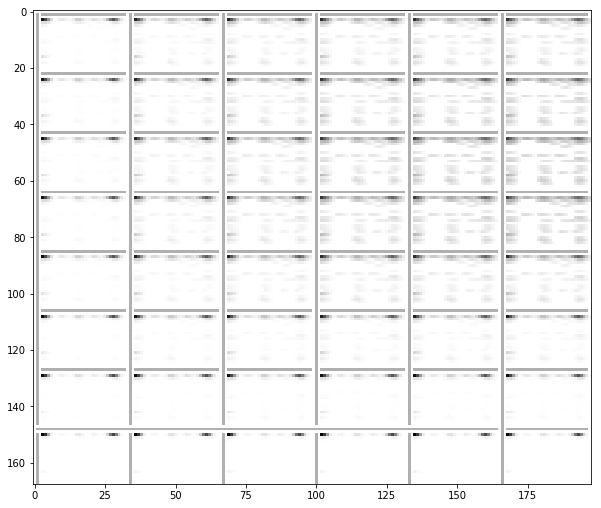

In [157]:
min_y = 0.01
max_y = 0.5
plot.latent(generator, batch_size,
       n=8,
       m=6,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

(2,) [0. 0.]


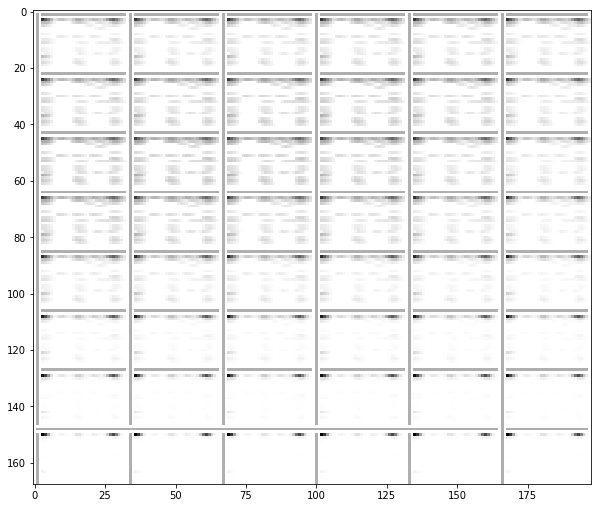

In [158]:
min_y2 = max_y
plot.latent(generator, batch_size,
       n=8,
       m=6,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)